In [1]:
%matplotlib inline

import numpy as np
import random
import pandas as pd
import requests as rq
import sys
import io
import os
from bs4 import BeautifulSoup
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import RMSprop
from collections import Counter
from datetime import datetime
import keras
import keras.callbacks
from keras.callbacks import TensorBoard
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import Callback


%load_ext tensorboard

2024-04-23 14:15:47.886315: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-23 14:15:47.931197: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# # code to run the dataset 
# YEARS = range(2010,2012)
# data = pd.DataFrame()
# for YEAR in YEARS:  
#     print(str(YEAR))
#     i_data = pd.read_csv('https://github.com/nflverse/nflverse-data/releases/download/pbp/' \
#                    'play_by_play_' + str(YEAR) + '.csv.gz',
#                    compression= 'gzip', low_memory= False)
#     data = pd.concat([data, i_data], sort=True)



Data Cleaning

In [3]:
##get data
##data is already from 2012-2020
data = pd.read_csv('cleaneddata.csv') # pandas data frame


#Variable Time Stamping
# Currently, each play is treated as a single timestep. If possible, 
# consider using multiple timesteps per sample to include more historical context.
# For instance, using the last n plays within the same drive as a sequence might help the model understand the context better and improve predictions.

##preprocessing

##filter to only patriots
#data = data.loc[(data['home_team'] == 'NE') | (data['away_team'] == 'NE')]

##removes 
data = data.loc[(data['desc'].str.startswith('('))]
data = data[data['play_type'] != 'qb_kneel']
data = data[data['play_type'] != 'no_play']
data = data[data['posteam'] == 'NE']
data = data.dropna(subset=['down'])
data = data.dropna(subset=['play_type'])
data = data.dropna(subset=['wp'])
data = data[(data['play_type'] == 'pass') | (data['play_type'] == 'run') | (data['play_type'] == 'punt') | (data['play_type'] == 'field_goal')]

# Extract year and month using string slicing
data['year'] = data['game_id'].str[:4].astype(int)
data['month'] = data['game_id'].str[5:7].astype(int)
# Create a new 'date' column with the 1st day of each extracted year and month


# Come back to this when we want to specify split spots  
# def parse_date(x):
#     parts = x.split('_')
#     year = int(parts[0])predictions = model.predict(X_test)

# Apply the function to the 'game_date' column
# data['date'] = data['game_id'].apply(parse_date)
# # Now you can sort by this 'date' column if needed
# data.sort_values(by='date', inplace=True)

# # And use the 'date' column for splitting your data, work with in the future to pick specific dates 
# #Right now not working because the months in the game_id are 01-12, when for pd.TimeStamp they need to be in 1-12. 
# split_date = pd.Timestamp(year=2018, month=12, day=1)  # Replace YYYY and MM with your split year and month
# train_data = data[data['date'] < split_date]
# test_data = data[data['date'] >= split_date]

 
##fixes playtype to be strictly pass or run 
##lables scrambles as passes
data.loc[data['pass']==1,'play_type'] = 'pass'
data.loc[data.rush==1,'play_type'] = 'run'

# columns are the strings 
# things to encode from strings to 1s and zeros
# season_type, 
columnsKeep = ['game_id', 'year','month','season_type','week','posteam','posteam_type','defteam','side_of_field','yardline_100','half_seconds_remaining','home_team','away_team',
               'game_seconds_remaining','game_half','drive','down','time','yrdln','ydstogo','desc','play_type','yards_gained','shotgun','no_huddle','qb_dropback','qb_kneel',
               'qb_spike','qb_scramble','pass_length','run_location','run_gap','home_timeouts_remaining','away_timeouts_remaining','total_home_score','total_away_score',
               'passer_player_name','receiver_player_name','rusher_player_name','play_type_nfl','roof','surface','temp','wind','home_coach','away_coach','game_stadium',
               'success', 'wp']

data = data[columnsKeep]

# print(data.head(5))

data.to_csv('finalized_data.csv', index=False)

/tmp/ipykernel_29966/583003650.py:3: DtypeWarning: Columns (45,179,180,189,190,197,198,203,204,205,206,218,219,220,222,224,226,253,254,255,260,262,263,283,284,294,295,301) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('cleaneddata.csv') # pandas data frame


In [4]:
print(len(data))

# Count occurrences of each play type
runCount = (data['play_type'] == 'run').sum()
passCount = (data['play_type'] == 'pass').sum()

print("Number of 'run' plays:", runCount)
print("Number of 'pass' plays:", passCount)

10489
Number of 'run' plays: 3942
Number of 'pass' plays: 5624


In [5]:
##check for nan values in data
for index, row in data.iterrows():
    if pd.isnull(row['play_type']):  # Check if the value in the 'down' column is NaN
        print(row['desc'])  # Print the value in the 'desc' column if 'down' is NaN

# wind and stadium had a lot of null 
## check for missing values in data
selected_features = ['down', 'drive', 'ydstogo', 'yardline_100', 'half_seconds_remaining', 'game_seconds_remaining','wp']
missing_values_features = data[selected_features].isnull().sum()
print("Missing values in selected features:")
print(missing_values_features)

# Check for missing values in the target
missing_values_target = data['play_type'].isnull().sum()
print("\nMissing values in target (play_type):", missing_values_target)


Missing values in selected features:
down                      0
drive                     0
ydstogo                   0
yardline_100              0
half_seconds_remaining    0
game_seconds_remaining    0
wp                        0
dtype: int64

Missing values in target (play_type): 0


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

features = data[['down','drive', 'ydstogo','yardline_100', 'half_seconds_remaining', 'game_seconds_remaining', 'wp']]
target = to_categorical(data['play_type'].map({'pass': 0, 'run': 1, 'field_goal': 2, 'punt': 3}))# Initialize the scaler 
scaler = StandardScaler() 

# Fit the scaler on the features and transform them 
features_scaled = scaler.fit_transform(features)

# Reshaping input data for LSTM [samples, time steps, features]
# Here, we assume each sample is a single time step
features_scaled = features_scaled.reshape((features_scaled.shape[0], 1, features_scaled.shape[1]))

# Talk to Nicolai and Ulrich if they think this is a good idea to split it up into drives as our time stamp. 
# 1 indicates that each sample consists of 1 timestep. This is a key detail: 
# it means you are treating each play as a separate, single-timestep sequence. T
# This is a simplification, as ideally, plays within a single drive might be treated as sequences to capture their temporal dependencies.

X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, shuffle = False)

#Initalize model
model = Sequential()

# input_shape corresponds to (time steps, features)
model.add(LSTM(units=64, return_sequences=True, input_shape=(1, features_scaled.shape[2])))
model.add(Dropout(0.2))  # Adding dropout to avoid overfitting

# Adding a second LSTM layer
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))

# Adding the output layer
# Since binary classification (pass/run), we use 1 unit with a sigmoid activation function
model.add(Dense(units=4, activation='sigmoid'))

# compilinh the model,
model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

#Training the model using the training data, 
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.1)


test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.3f}, Test Loss: {test_loss:.3f}')



#Accuracy
#Definition: This is the metric that measures the performance of your model on the entire training dataset. In simpler terms, it represents the percentage of correct predictions that the model makes when it is fed the training data.
#Purpose: Accuracy on the training set helps you understand how well the model is learning the intended patterns from the data it is trained on. It provides a direct measure of the model's effectiveness in fitting the data.

# Validation Accuracy (val_accuracy)
# Definition: This is the metric that measures the performance of your model on a separate validation dataset that is not used for the training of the model. 
# The validation set is a subset of the data that is held back from the training process and is used specifically to assess model performance during training.
# Purpose: Validation accuracy is critical because it gives an early indicator of how well the model is likely to perform on unseen data, helping to diagnose issues such as overfitting. 
# Overfitting occurs when a model learns patterns specific to the training data, but these patterns do not generalize to new data

Epoch 1/30
118/118 [==============================] - 5s 12ms/step - loss: 0.7307 - accuracy: 0.6275 - val_loss: 0.6056 - val_accuracy: 0.6786
Epoch 2/30
118/118 [==============================] - 1s 5ms/step - loss: 0.6046 - accuracy: 0.6836 - val_loss: 0.5814 - val_accuracy: 0.6964
Epoch 3/30
118/118 [==============================] - 1s 5ms/step - loss: 0.5958 - accuracy: 0.6802 - val_loss: 0.5626 - val_accuracy: 0.6905
Epoch 4/30
118/118 [==============================] - 1s 5ms/step - loss: 0.5821 - accuracy: 0.6901 - val_loss: 0.5566 - val_accuracy: 0.7083
Epoch 5/30
118/118 [==============================] - 1s 5ms/step - loss: 0.5781 - accuracy: 0.6897 - val_loss: 0.5658 - val_accuracy: 0.7071
Epoch 6/30
118/118 [==============================] - 1s 5ms/step - loss: 0.5735 - accuracy: 0.6909 - val_loss: 0.5539 - val_accuracy: 0.7048
Epoch 7/30
118/118 [==============================] - 1s 5ms/step - loss: 0.5680 - accuracy: 0.6939 - val_loss: 0.5529 - val_accuracy: 0.7095
Epoch

In [11]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
y_test_classes = np.argmax(y_test, axis=1)
print("Classification Report:")
print(classification_report(y_test_classes, predicted_classes))

print("Confusion Matrix:")
print(confusion_matrix(y_test_classes, predicted_classes))



66/66 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.92      0.75      1083
           1       0.75      0.29      0.42       829
           2       0.79      0.93      0.85        56
           3       1.00      0.92      0.96       130

    accuracy                           0.67      2098
   macro avg       0.79      0.77      0.74      2098
weighted avg       0.70      0.67      0.63      2098

Confusion Matrix:
[[997  78   8   0]
 [584 241   4   0]
 [  3   1  52   0]
 [  5   3   2 120]]


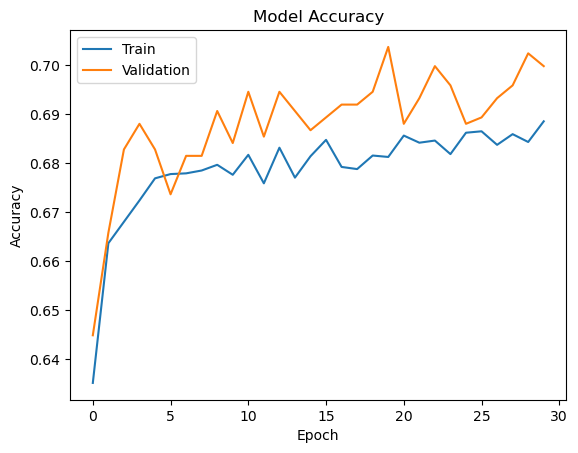

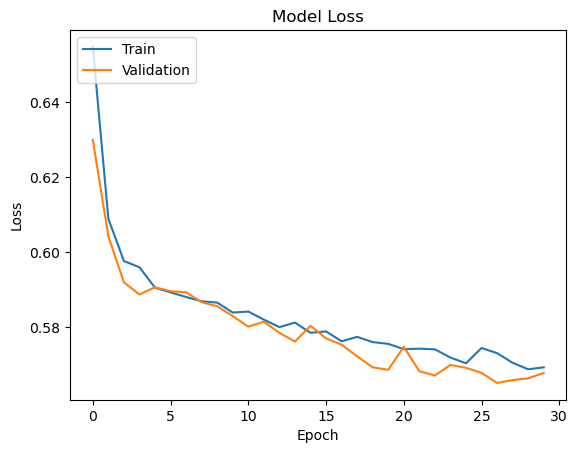

In [ ]:
import matplotlib.pyplot as plt

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [1]:
#
# focus more on data tarnsformations 

In [ ]:
# length of X train, and nulls in the x,train, x_test, y_train, y_test 
print(len(X_train))
nan_indices_X = np.isnan(X_train)
nan_count_X = np.sum(nan_indices_X)
print(nan_count_X)

nan_indices_X_test = np.isnan(X_test)
nan_count_X_test = np.sum(nan_indices_X_test)
print(nan_count_X_test)

nan_indices_y = np.isnan(y_train)
nan_count_y = np.sum(nan_indices_y)
print(nan_count_y)

nan_indices_Y_test = np.isnan(y_test)
nan_count_Y_test = np.sum(nan_indices_Y_test)
print(nan_count_Y_test)

print("Shape of X_train:", X_train.shape)

7652
0
0
0
0
Shape of X_train: (7652, 1, 7)
